## Chapter 4

In [6]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.interpolate import griddata
import pandas as pd
import arviz as az

In [7]:
%config InLineBackEnd.figure_format = 'retina'
az.style.use('arviz-darkgrid')

## Random walk simulation

In [48]:
pos = np.random.choice([-1,1],size=(16,1000)).sum(0)

Text(0, 0.5, 'density')

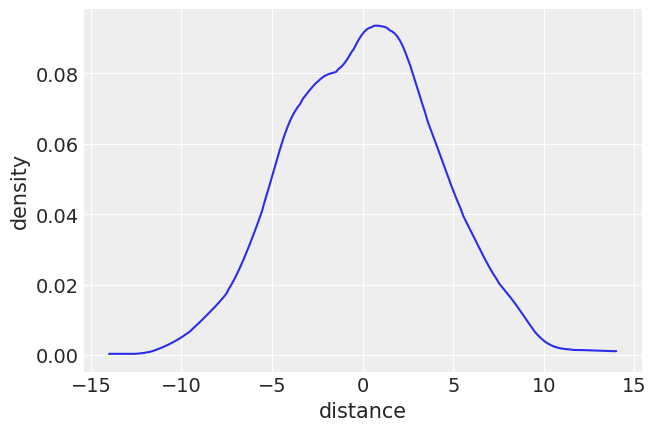

In [49]:
az.plot_kde(pos)
plt.xlabel('distance')
plt.ylabel('density')

## Multiplicative random walk with small steps

In [50]:
pos = np.random.choice([1,1.1],size=(12,1000)).prod(0)

Text(0, 0.5, 'density')

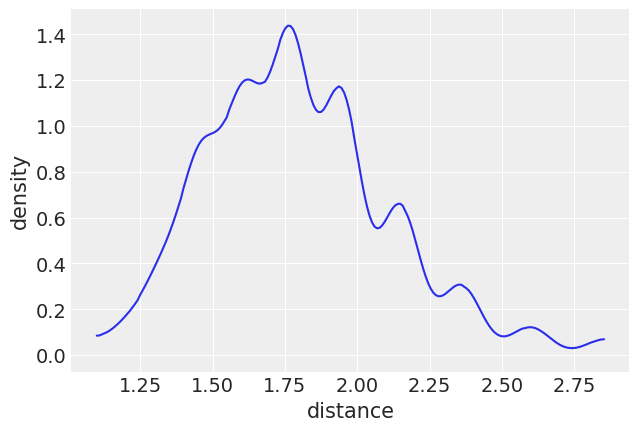

In [51]:
az.plot_kde(pos)
plt.xlabel('distance')
plt.ylabel('density')

## multiplicative random walk with big steps

In [52]:
pos = np.random.choice([1,1.5],size=(12,10000)).prod(0)

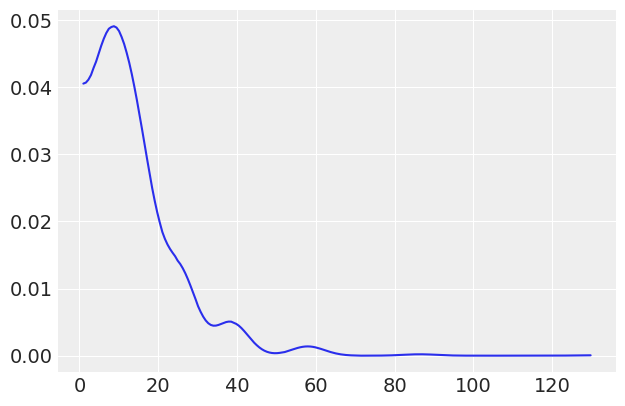

In [53]:
az.plot_kde(pos)

## multiplicative random walk with really small steps

In [54]:
pos = np.random.choice([1,1.01],size=(12,10000)).prod(0)

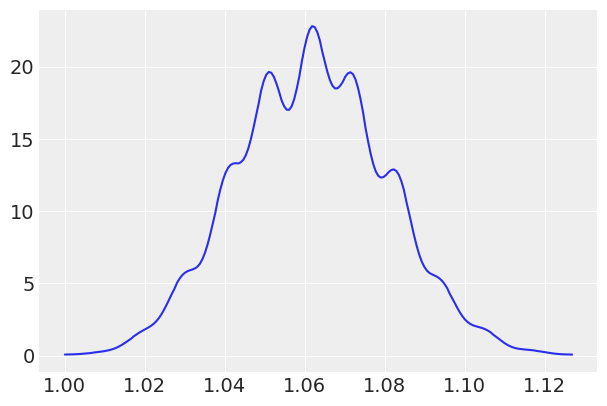

In [55]:
az.plot_kde(pos)

## Logarithm of multiplicative random walk with big steps

In [56]:
pos = np.log(np.random.choice([1,1.5],size=(12,10000)).prod(0))

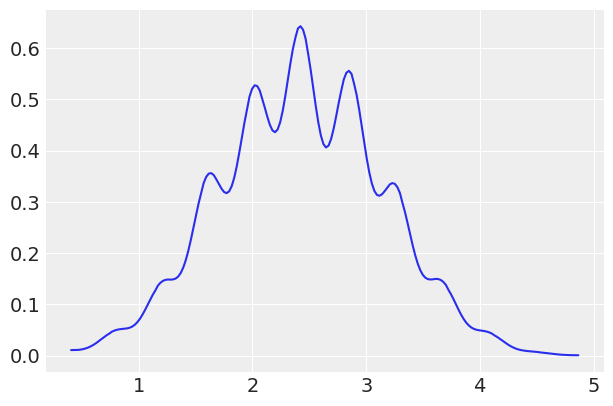

In [57]:
az.plot_kde(pos)

# Definining a bayesian model

$$ x \sim \textrm{Normal}(\mu_i,\sigma) $$

$$ P(p \mid w,n) = \frac{\textrm{Binomial}(w \mid n,p)  \textrm{Uniform}(p \mid 0,1)}{\int \textrm{Binomial}(w \mid n,p)\textrm{Uniform}(p \mid 0,1) dp} $$

$$ P(a \mid b) = \frac{P(b \mid a) P(a)}{P(b)} $$

# !Kung San Data

In [58]:
df = pd.read_csv('../resources/Rethinking/Data/Howell1.csv', sep = ';')

In [59]:
df.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

## Visualizing data

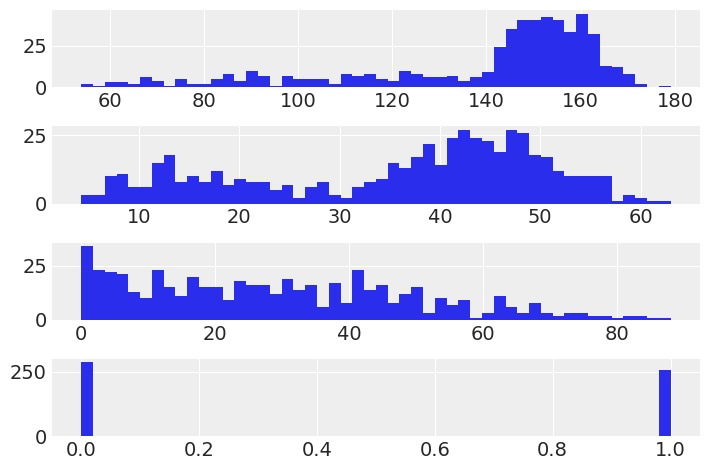

In [60]:
_,ax = plt.subplots(4)
ax[0].hist(df['height'], bins = 50);
ax[1].hist(df['weight'], bins = 50);
ax[2].hist(df['age'], bins = 50);
ax[3].hist(df['male'], bins = 50);
_.tight_layout()

## Height distribution of adults

In [61]:
adult_height = df[df['age'] >= 18]['height']

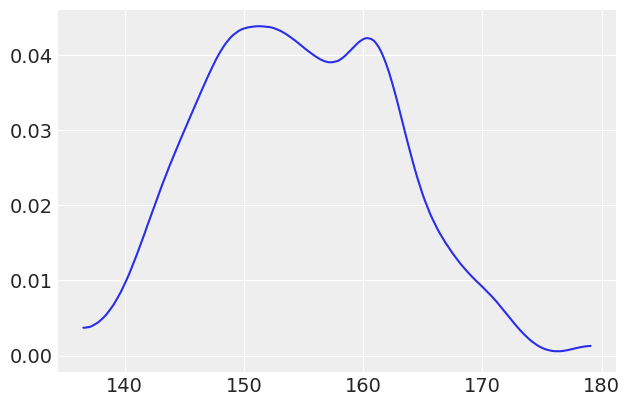

In [62]:
az.plot_kde(adult_height)

# Model

$$ h \sim N(\mu, \sigma) $$

### Model priors

$$ Pr(\mu, \sigma) = Pr(\mu)Pr(\sigma) $$

### Complete description

$$ h_i \sim N(\mu, \sigma) $$
$$ \mu_i \sim N(178, 20) $$
$$ \sigma \sim U(0,50) $$

## Visualizing priors

In [63]:
x = np.linspace(50,250,100)
x2 = np.linspace(-10,60,100)
y = stats.norm.pdf(x,loc=178, scale = 20)
y2 = stats.uniform.pdf(x2,0,50)

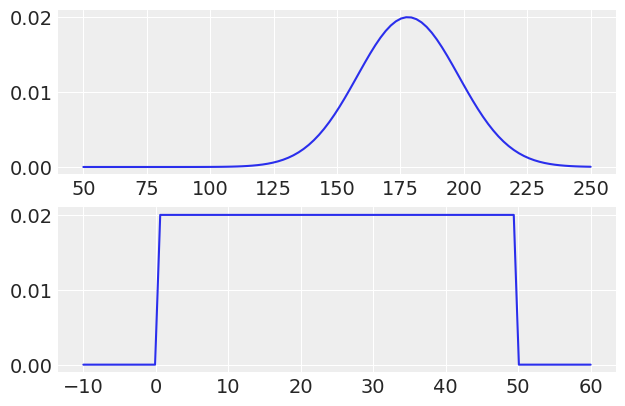

In [64]:
_,fig = plt.subplots(2)
fig[0].plot(x,y);
fig[1].plot(x2,y2);

## Sampling from prior

In [65]:
nsample = 1000
sample_mu = stats.norm.rvs(178, 20,size=nsample)
sample_sigma = stats.uniform.rvs(0,50,size=nsample)


## Propagating uncertainty from parameters to prior (posterior) height

In [66]:
prior_h = stats.norm.rvs(sample_mu, sample_sigma, size =nsample)

## Visualizing priors

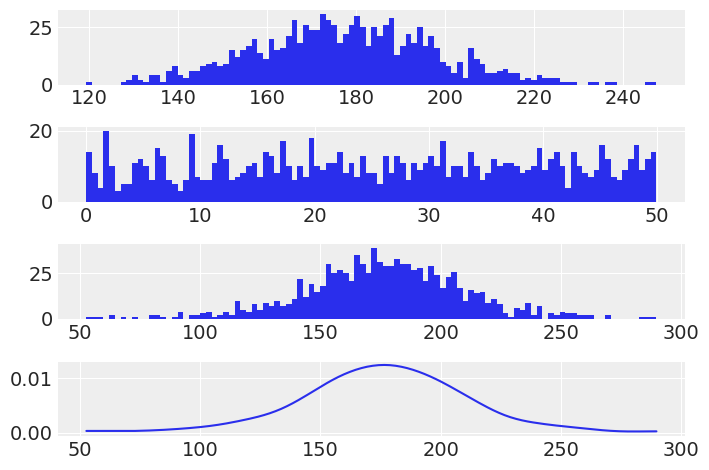

In [67]:
fig,ax = plt.subplots(4)
ax[0].hist(sample_mu, bins = 100);
ax[1].hist(sample_sigma, bins = 100);
ax[2].hist(prior_h, bins=100);
az.plot_kde(prior_h, ax=ax[3]);
fig.tight_layout()

$$ Pr(A \mid B) =\frac{ Pr(B \mid A) Pr(A)}{Pr(B)} $$

## Calculate posterior using grid approximation

In [68]:
grid = np.mgrid[140:160:0.1,4:9:0.1].reshape(2,-1).T

In [69]:
likelihood = [sum(stats.norm.logpdf(adult_height, grid[:,0][i], grid[:,1][i])) for i in range(len(grid))]

In [70]:
posterior = likelihood + stats.norm.logpdf(grid[:,0], loc = 178, scale = 20) + stats.uniform.logpdf(grid[:,1], loc = 0, scale = 50)

In [71]:
result = np.exp(posterior-max(posterior))

In [72]:
xi = np.linspace(grid[:,0].min(),grid[:,0].max(),100)
yi = np.linspace(grid[:,1].min(),grid[:,1].max(),100)
zi = griddata((grid[:,0], grid[:,1]), result, (xi[None, :], yi[:,None]))

In [38]:
np.mgrid[140:160:0.1,4:9:0.1].reshape(2,-1).T

array([[140. ,   4. ],
       [140. ,   4.1],
       [140. ,   4.2],
       ...,
       [159.9,   8.7],
       [159.9,   8.8],
       [159.9,   8.9]])

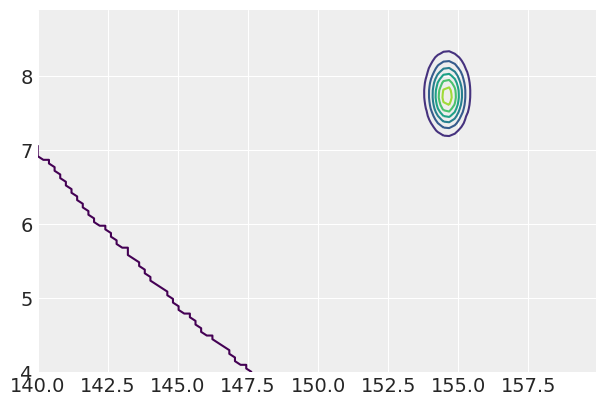

In [78]:
plt.contour(xi,yi,zi)

## Sampling from the posterior

In [88]:
sample_rows = np.random.choice(len(result), size = int(1e4), p=result/result.sum())

In [89]:
sample_mu = grid[:,0][sample_rows]
sample_sigma = grid[:,1][sample_rows]

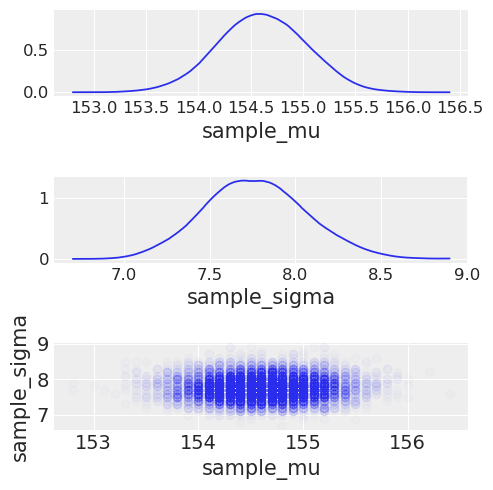

In [106]:
fig,ax = plt.subplots(3,figsize = (5,5))
az.plot_kde(sample_mu, ax = ax[0])
ax[0].set_xlabel('sample_mu')
az.plot_kde(sample_sigma, ax = ax[1])
ax[1].set_xlabel('sample_sigma')
ax[2].plot(sample_mu, sample_sigma, 'o', alpha = 0.01)
ax[2].set_xlabel('sample_mu')
ax[2].set_ylabel('sample_sigma')
fig.tight_layout()

In [109]:
pm.stats.hpd(sample_mu)

array([153.8, 155.4])

In [110]:
pm.stats.hpd(sample_sigma)

array([7.3, 8.4])

# Using pymc3 for same analysis

In [8]:
df = pd.read_csv('../resources/Rethinking/Data/Howell1.csv', sep=';')

In [9]:
df.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041915  41.0     1
4  145.415  41.276872  51.0     0

In [10]:
adultheight = df[df['age'] >= 18]['height']
adultweight = df[df['age'] >= 18]['weight']

$$ h_i \sim \textrm{Normal}(\mu, \sigma) $$
$$ \mu \sim \textrm{Normal}(178, 20) $$
$$ \sigma \sim \textrm{Uniform}(0,50) $$

In [11]:
with pm.Model() as m4_1:
    mu = pm.Normal('mu', mu=178, sd=20)
    sigma = pm.Uniform('sigma', lower = 0, upper = 50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed = adultheight)
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1612.98draws/s]


mean    sd  hpd_5.5%  hpd_94.5%  mcse_mean  mcse_sd  ess_mean  \
mu     154.60  0.42    153.94     155.30       0.01      0.0    3756.0   
sigma    7.77  0.30      7.30       8.25       0.00      0.0    3891.0   

       ess_sd  ess_bulk  ess_tail  r_hat  
mu     3756.0    3750.0    2524.0    1.0  
sigma  3881.0    3896.0    3282.0    1.0

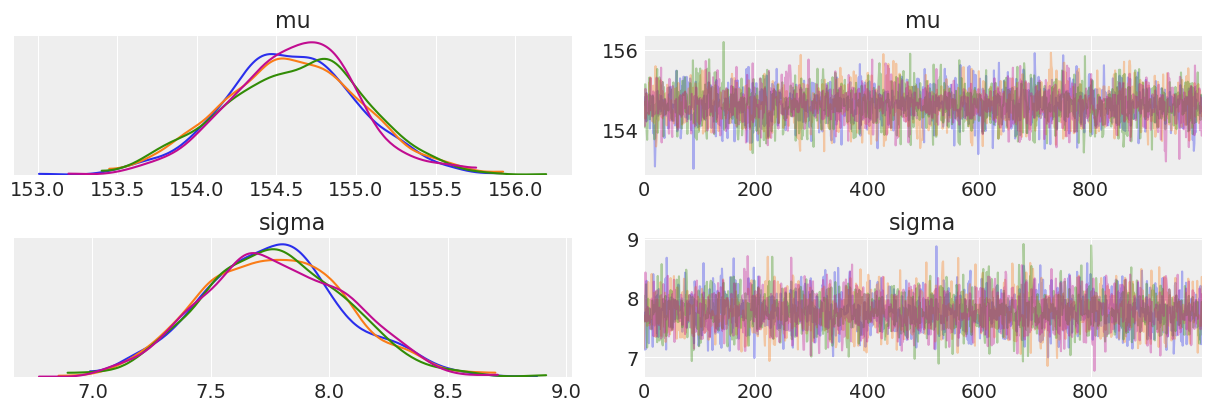

In [12]:
az.plot_trace(trace_4_1)
az.summary(trace_4_1, credible_interval=.89).round(2)

## Calculating correlation and covariance from sample

In [13]:
trace_df = pm.trace_to_dataframe(trace_4_1)

In [14]:
trace_df.cov()

mu     sigma
mu     0.179222 -0.000891
sigma -0.000891  0.089662

In [15]:
np.diag(trace_df.cov())

array([0.17922201, 0.08966198])

In [16]:
trace_df.corr()

mu     sigma
mu     1.000000 -0.007027
sigma -0.007027  1.000000

# Adding a predictor

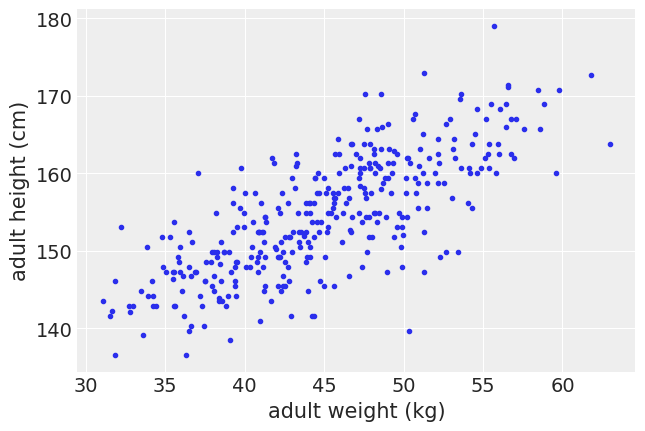

In [17]:
plt.plot(adultweight,adultheight,'.')
plt.xlabel('adult weight (kg)');
plt.ylabel('adult height (cm)');

## Model description

$$ h_i \sim N(\mu_i, \sigma) $$
$$ \mu_i = \alpha + \beta (x_i - \bar{x})  $$
$$ \alpha \sim N(178, 20) $$
$$ \beta \sim N(0,10) $$
$$ \sigma \sim U(0,50) $$

In [18]:
df['weight_c'] =df['weight'] - df['weight'].mean()

In [19]:
adult_df = df[df['age'] >= 18]

In [20]:
adult_df.head(3)

height     weight   age  male   weight_c
0  151.765  47.825606  63.0     1  12.214989
1  139.700  36.485807  63.0     0   0.875189
2  136.525  31.864838  65.0     0  -3.745780

In [21]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=178, sd = 100)
    beta = pm.Normal('beta', mu=0, sd=10)
    mu = alpha + beta*(adult_df['weight_c'])
    sigma = pm.Uniform('sigma', lower = 0, upper = 50)
    height = pm.Normal('heights', mu = mu, sd = sigma, observed = adult_df['height'])
    trace_model = pm.sample(1000, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1644.63draws/s]


In [22]:
az.summary(trace_model)

mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha  146.108  0.484  145.184  146.966      0.010    0.007    2243.0  2243.0   
beta     0.905  0.042    0.824    0.981      0.001    0.001    2156.0  2156.0   
sigma    5.105  0.190    4.767    5.486      0.004    0.003    2505.0  2492.0   

       ess_bulk  ess_tail  r_hat  
alpha    2240.0    2392.0    1.0  
beta     2145.0    2387.0    1.0  
sigma    2527.0    2343.0    1.0

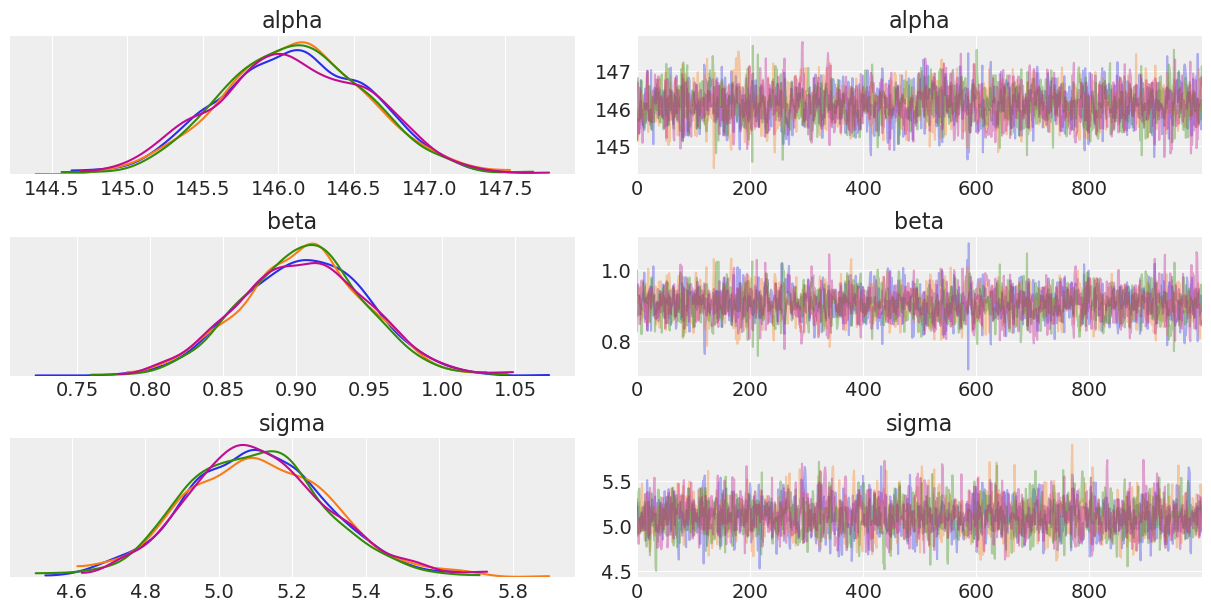

In [23]:
az.plot_trace(trace_model);

In [24]:
trace_df = pm.trace_to_dataframe(trace_model)

In [25]:
trace_df.head(3)

alpha      beta     sigma
0  145.166688  0.951669  5.298132
1  145.284238  0.928279  5.157949
2  145.699010  0.958910  5.214721

In [26]:
trace_df.corr().round(3)

alpha   beta  sigma
alpha  1.000 -0.831 -0.024
beta  -0.831  1.000  0.040
sigma -0.024  0.040  1.000

In [27]:
choices = np.random.choice(np.arange(4000),size=100)

In [28]:
x=np.linspace(-20,30,100)

In [29]:
y = trace_df['alpha'][choices].values+np.outer(x,trace_df['beta'][choices].values)

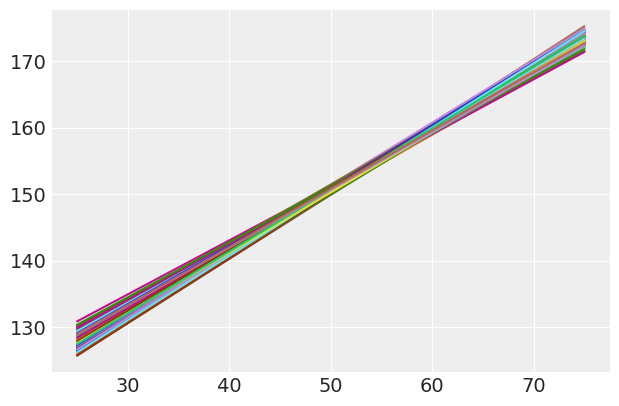

In [30]:
plt.plot(x+adult_df.weight.mean(),y);

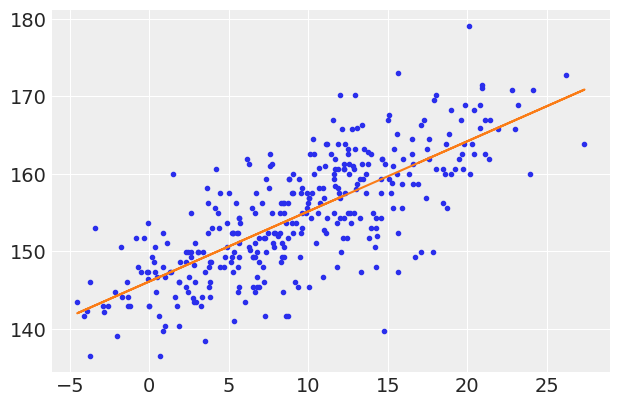

In [32]:
plt.plot(adult_df.weight_c, adult_df.height, '.')
plt.plot(adult_df.weight_c, trace_df.alpha.mean()+trace_df.beta.mean()*(adult_df.weight_c))

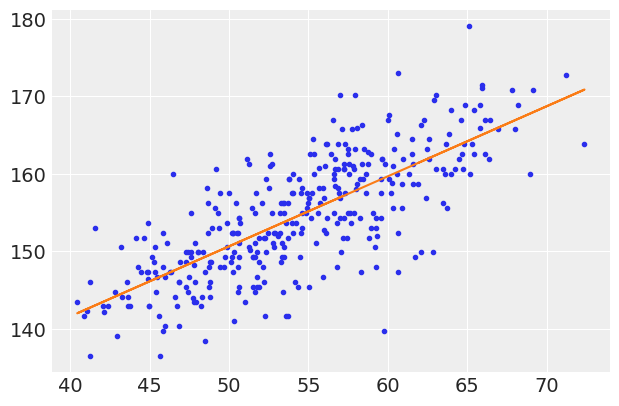

In [39]:
plt.plot(adult_df.weight_c+adult_df.weight.mean(), adult_df.height, '.')
plt.plot(adult_df.weight_c+adult_df.weight.mean(), trace_df.alpha.mean()+trace_df.beta.mean()*(adult_df.weight_c))

In [40]:
az.summary(trace_model)

mean     sd   hpd_3%  hpd_97%  mcse_mean  mcse_sd  ess_mean  ess_sd  \
alpha  146.108  0.484  145.184  146.966      0.010    0.007    2243.0  2243.0   
beta     0.905  0.042    0.824    0.981      0.001    0.001    2156.0  2156.0   
sigma    5.105  0.190    4.767    5.486      0.004    0.003    2505.0  2492.0   

       ess_bulk  ess_tail  r_hat  
alpha    2240.0    2392.0    1.0  
beta     2145.0    2387.0    1.0  
sigma    2527.0    2343.0    1.0

## Plot the first ten lines in the sample

In [45]:
x = np.linspace(30,60,100)
y = trace_df.alpha[:10].values + np.outer(x,trace_df.beta[:10].values)

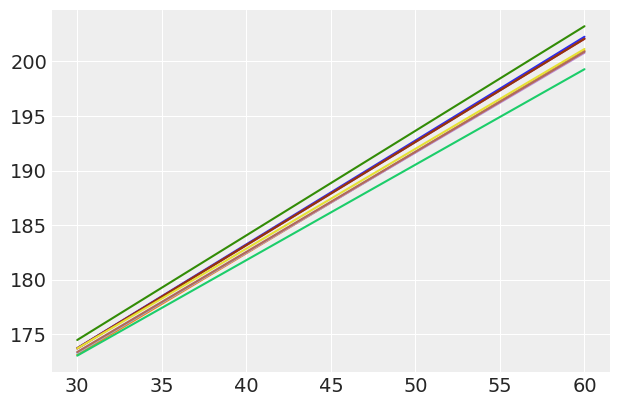

In [46]:
plt.plot(x,y);

# Sampling from the first N samples in the dataframe

In [56]:
N=[10,50,150,352][0]

In [125]:
N = [10, 50, 150, 352][3]
with pm.Model() as m_N:
    alpha = pm.Normal('alpha', mu=178, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    mu = pm.Deterministic('mu', alpha + beta * adult_df.weight[:N])
    height_hat = pm.Normal('height_hat', mu=mu, sd=sigma, observed=adult_df.height[:N])
    trace_N = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
Sampling 4 chains: 100%|██████████| 8000/8000 [00:08<00:00, 930.59draws/s] 


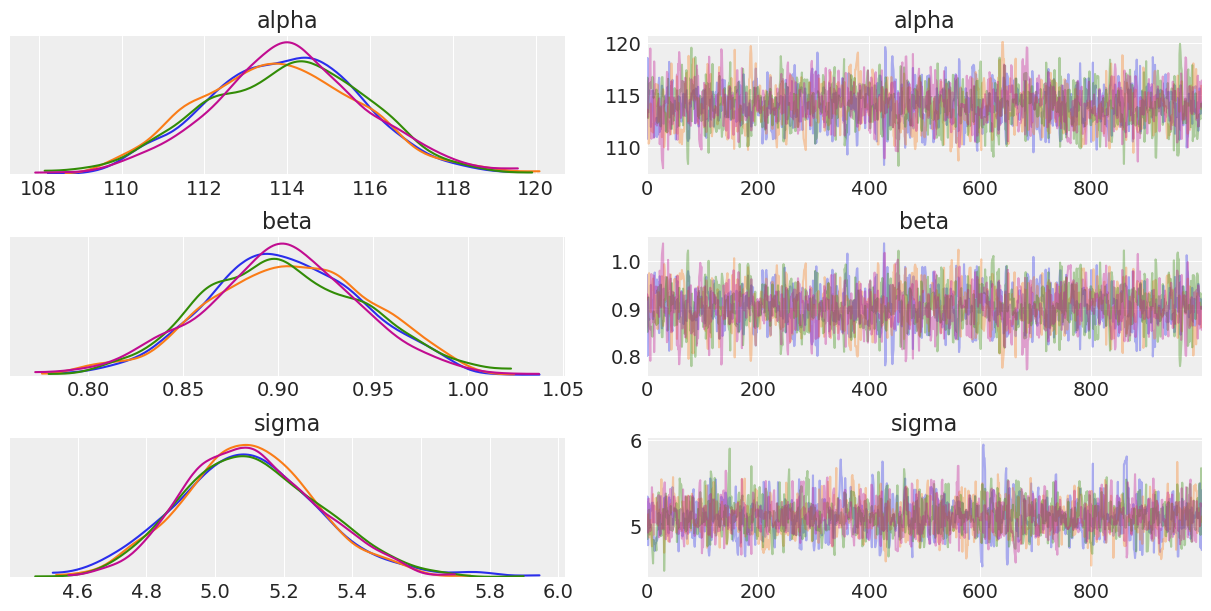

In [126]:
chain_N = trace_N
az.plot_trace(chain_N, var_names='~mu');

## My solution

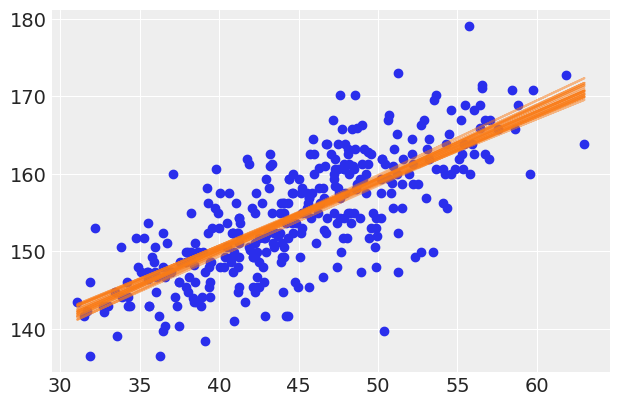

In [127]:
plt.plot(adult_df.weight[:N], adult_df.height[:N], 'C0o')
rows =  np.random.choice(np.arange(len(trace_N)),20)
x=adult_df.weight[:N]
y=trace_N['alpha'][rows] + np.outer(adult_df.weight[:N].values,trace_N['beta'][rows]);
plt.plot(x,y, 'C1-', alpha=0.5);

19.6 ms ± 6.52 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


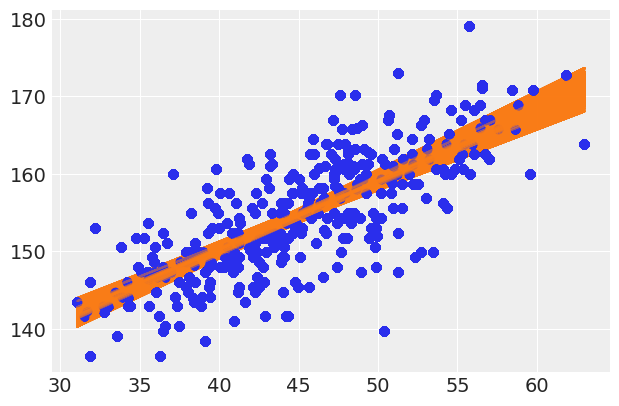

In [128]:
%%timeit
plt.plot(adult_df.weight[:N], adult_df.height[:N], 'C0o')
rows =  np.random.choice(np.arange(len(trace_N)),20)
x=adult_df.weight[:N]
y=trace_N['alpha'][rows] + np.outer(adult_df.weight[:N].values,trace_N['beta'][rows]);
plt.plot(x,y, 'C1-', alpha=0.5);

## Book solution

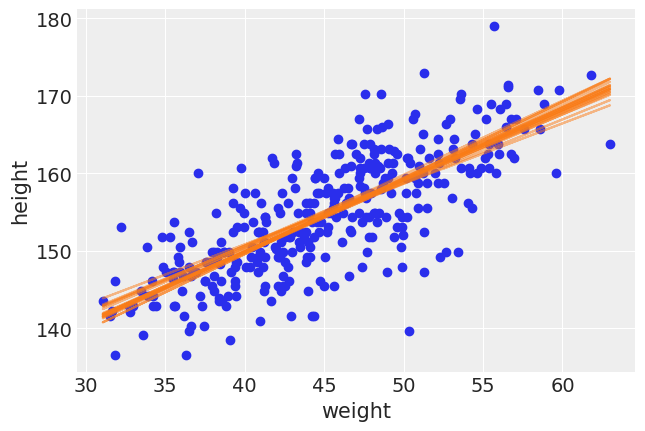

In [129]:
plt.plot(adult_df.weight[:N], adult_df.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(adult_df.weight[:N], chain_N['alpha'][idx] + chain_N['beta'][idx] * adult_df.weight[:N], 'C1-', alpha=0.5)
plt.xlabel(adult_df.columns[1])
plt.ylabel(adult_df.columns[0]);

42.8 ms ± 3.34 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


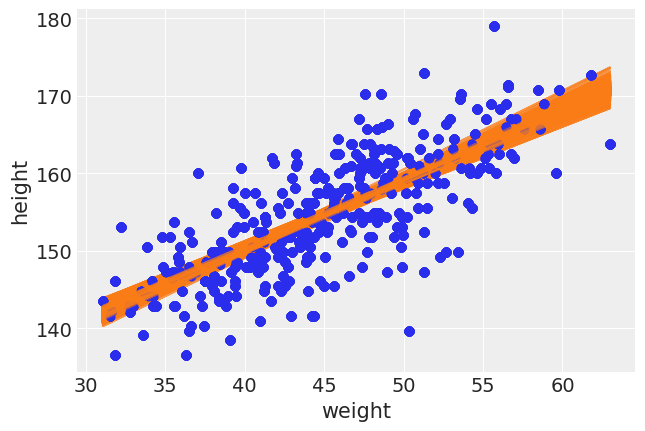

In [130]:
%%timeit
plt.plot(adult_df.weight[:N], adult_df.height[:N], 'C0o')
for _ in range(0, 20):
    idx = np.random.randint(len(chain_N))
    plt.plot(adult_df.weight[:N], chain_N['alpha'][idx] + chain_N['beta'][idx] * adult_df.weight[:N], 'C1-', alpha=0.5)
plt.xlabel(adult_df.columns[1])
plt.ylabel(adult_df.columns[0]);

In [133]:
mu_at_50 = trace_N['alpha']+trace_N['beta']*[50]

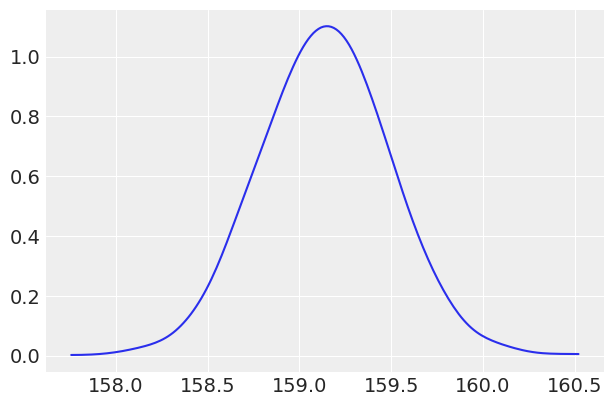

In [134]:
az.plot_kde(mu_at_50)

In [135]:
az.hpd(mu_at_50, credible_interval = .89)

array([158.58891517, 159.69334532])

In [136]:
df_trace_N = pm.trace_to_dataframe(chain_N).filter(regex=('mu.*'))
df_trace_N.head()

mu__0       mu__1       mu__2       mu__3       mu__4       mu__5  \
0  157.187568  146.171812  141.682891  162.254816  150.825969  171.921142   
1  156.850684  147.769854  144.069416  161.027866  151.606505  168.996294   
2  157.367085  147.111297  142.932063  162.084748  151.444367  171.084203   
3  157.479053  147.007842  142.740823  162.295810  151.431928  171.484298   
4  157.341428  147.400285  143.349269  161.914353  151.600418  170.637706   

        mu__6       mu__7       mu__8       mu__9  ...     mu__342  \
0  147.879254  164.623203  144.602067  163.659325  ...  153.497290   
1  149.177383  162.980244  146.475836  162.185672  ...  153.808606   
2  148.700944  164.289743  145.649847  163.392361  ...  153.931396   
3  148.630879  164.547120  145.515694  163.630889  ...  153.971197   
4  148.941162  164.051699  145.983672  163.181849  ...  154.011145   

      mu__343     mu__344     mu__345     mu__346     mu__347     mu__348  \
0  157.242647  149.008369  150.605654  150.385339  156.416465  143.996200   
1  156.896088  150.108168  151.424888  151.243272  156.215026  145.976390   
2  157.418364  149.752162  151.239252  151.034136  156.649180  145.085779   
3  157.531409  149.704178  151.222504  151.013080  156.746068  144.939777   
4  157.391134  149.960129  151.401595  151.202772  156.645548  145.436909   

      mu__349     mu__350     mu__351  
0  161.401095  163.246234  161.759107  
1  160.324102  161.845141  160.619229  
2  161.289925  163.007769  161.623238  
3  161.484291  163.238219  161.824605  
4  161.143915  162.809056  161.467002  

[5 rows x 352 columns]

In [137]:
weight_seq = np.arange(25, 71)
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
chain_N_thinned = chain_N[::10]
mu_pred = np.zeros((len(weight_seq), len(chain_N_thinned)*chain_N.nchains))
for i, w in enumerate(weight_seq):
    mu_pred[i] = chain_N_thinned['alpha'] + chain_N_thinned['beta'] * w

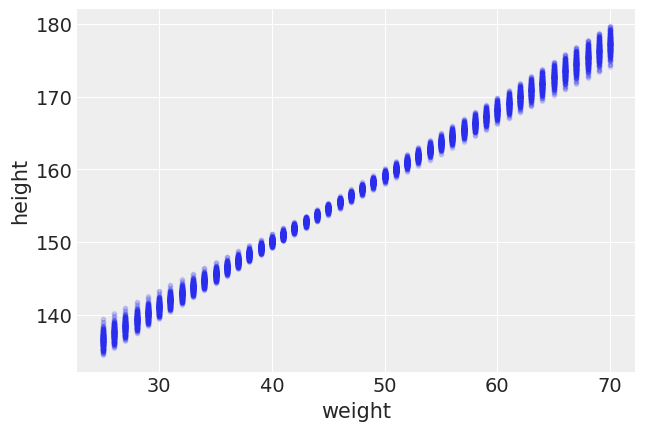

In [138]:
plt.plot(weight_seq, mu_pred, 'C0.', alpha=0.1)
plt.xlabel('weight')
plt.ylabel('height');

In [145]:
mu_mean = mu_pred.mean(1)
mu_hpd = az.hpd(mu_pred.T, credible_interval=0.99)

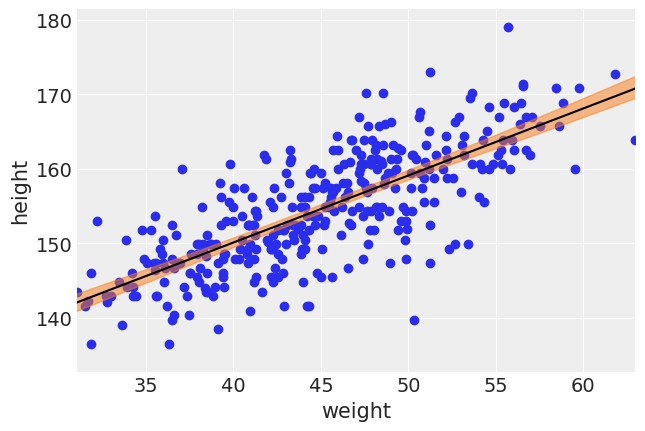

In [146]:
plt.scatter(adult_df.weight[:N], adult_df.height[:N])
plt.plot(weight_seq, mu_mean, 'k')
az.plot_hpd(weight_seq, mu_pred.T)
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(adult_df.weight[:N].min(), adult_df.weight[:N].max());

In [147]:
height_pred = pm.sample_posterior_predictive(chain_N, 200, m_N)

100%|██████████| 200/200 [00:00<00:00, 1023.14it/s]


In [148]:
height_pred_hpd = az.hpd(height_pred['height_hat'])

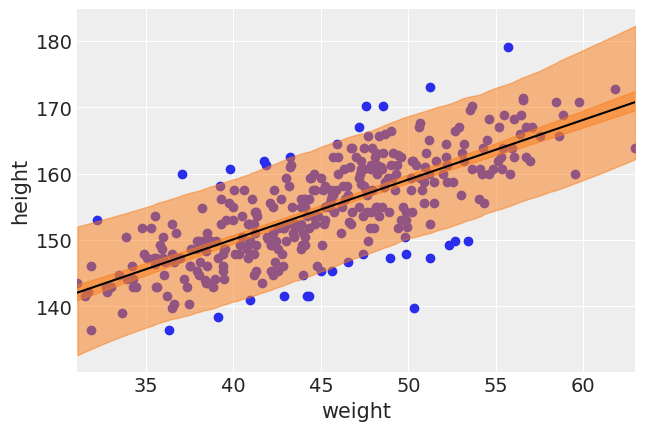

In [151]:
plt.scatter(adult_df.weight[:N], adult_df.height[:N])
az.plot_hpd(weight_seq, mu_pred.T)
az.plot_hpd(adult_df.weight[:N], height_pred['height_hat'])
plt.plot(weight_seq, mu_mean, 'k')
plt.xlabel('weight')
plt.ylabel('height')
plt.xlim(adult_df.weight[:N].min(), adult_df.weight[:N].max());